In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-15 22:57:26.540693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
import os

directory = os.fsencode( "../../../../../datax/scratch/pma/reverse_search/train/")
count = 0
data = []
for folder in os.listdir(directory):
    print(folder)
    for subfolder in os.listdir(directory+folder):
        back = os.fsencode( "/")
        for file in os.listdir(directory+folder+back+subfolder):
            file_directory = str(os.path.join(directory+folder+back+subfolder, file)).replace('b', '').replace("'","")
            if 'filtered.npy' in file_directory:
                data.append(np.load(str(file_directory)))
                count += 1
    

b'HIP44295-23'
b'HIP63503-523'
b'AND_XI-2274'
b'HIP36393-1253'
b'HIP48477-589'


(666733, 16, 256)


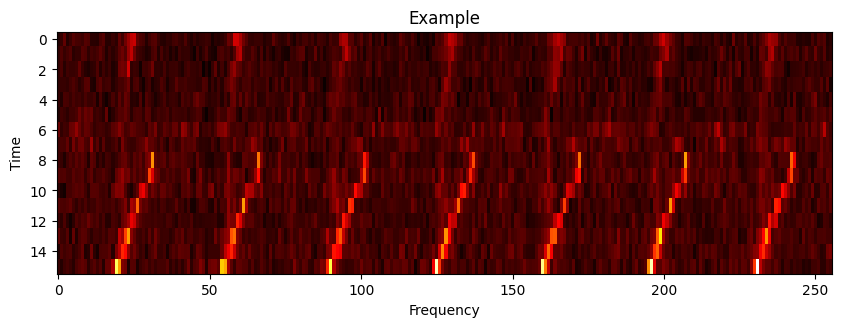

In [3]:
import numpy as np
data = np.vstack(data)
print(data.shape)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [4]:
from tqdm import tqdm

def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    for i in tqdm(range(data.shape[0])):
        data[i,:,:] = normalize(data[i,:,:])
    return data

data = np.expand_dims(normalize_data(data), axis = -1)
print(data[0,:,:].max(), data[0,:,:].min())

100%|████████████████████████████████████████████████████████████████████| 666733/666733 [01:29<00:00, 7471.36it/s]

1.0 0.0


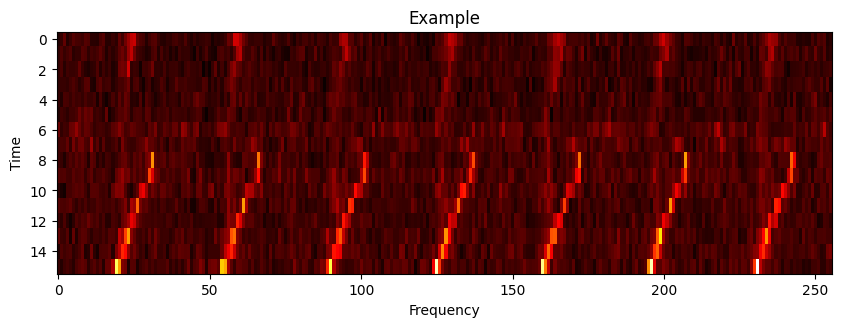

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,5))
plt.title("Example")
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.imshow(data[1000, :, :], cmap='hot', aspect=5)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.33, random_state=42)

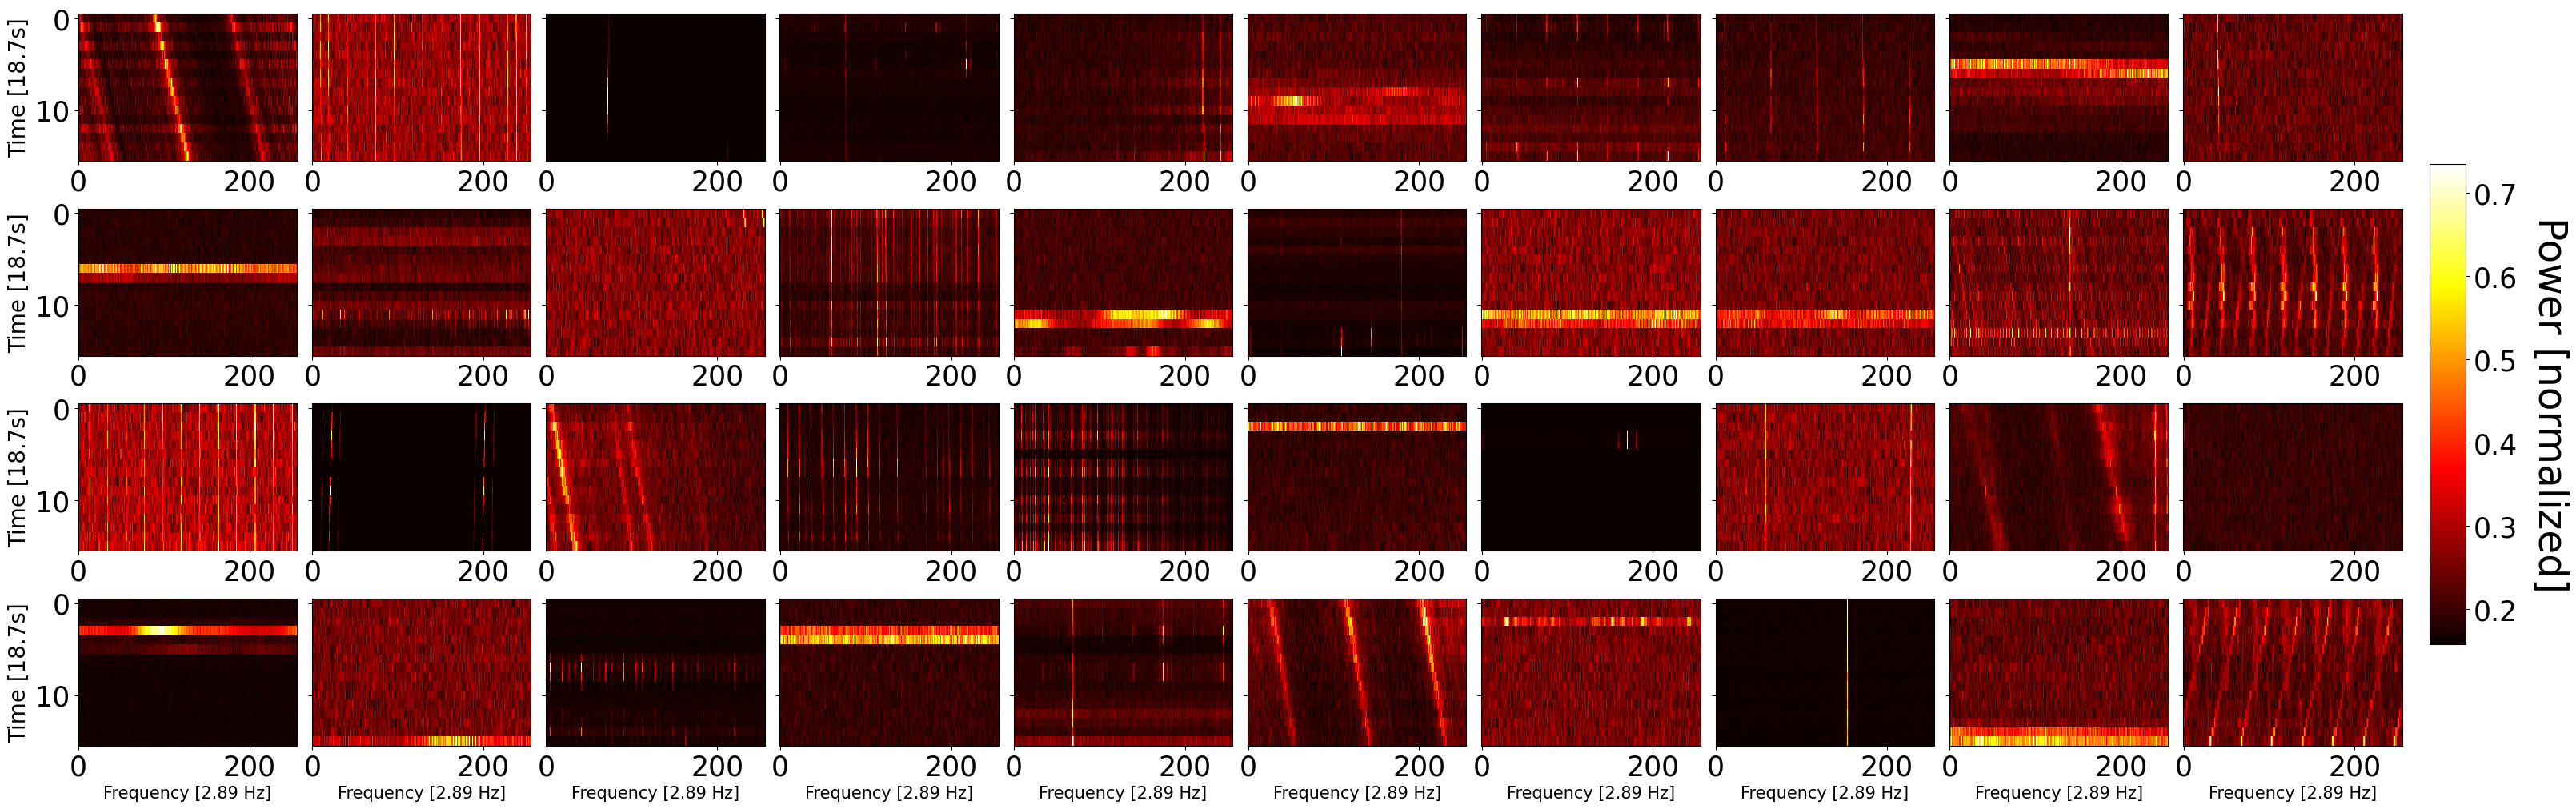

In [115]:
ind = np.random.randint(0, X_train.shape[0], size=(10, 10))
font_size = 25
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(4, 10, sharey=True, figsize=(30, 10), constrained_layout=True)

for j in range(10):
    for i in range(4):
        inde = ind[i, j]
        ax[i,j].imshow(X_train[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
        if i == 3:
            ax[i,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-10)  
        if j ==0:
            ax[i,j].set_ylabel("Time [18.7s]",  fontsize=font_size-5)  
            
        
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/training_examples.pdf", format="pdf")


# Encoder Model

In [7]:
latent_dim = 5
time_samples = X_train.shape[1]
freq_sample =  X_train.shape[2]
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
z = layers.Dense(latent_dim, name="latent")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 16, 256, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 128, 16)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 128, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 128, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 64, 32)       0   

# Decoder Model

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                192       
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 4096)              135168    
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 16, 8, 32)         0   

# Training Model

In [9]:
from keras.callbacks import EarlyStopping
from AE import AE
es = EarlyStopping(monitor='val_test_reconstruction_loss', mode='min', verbose=1, patience=10)

autoencoder = AE(encoder, decoder)
autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4))
history = autoencoder.fit(X_train, validation_data = (X_test[:20_000,:,:,:],X_test[:20_000,:,:,:]),
                  epochs=200, batch_size = 128, callbacks=[es])

/home/pma/.conda/envs/ml_jax/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-12-15 22:59:43.877685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7318913024 exceeds 10% of free system memory.
2022-12-15 22:59:49.398621: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7318913024 exceeds 10% of free system memory.


Epoch 1/200


2022-12-15 22:59:57.933450: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3489/3490 [============================>.] - ETA: 0s - loss: 27.1588 - reconstruction_loss: 20.7327

2022-12-15 23:03:40.753733: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3490/3490 [==============================] - 241s 67ms/step - loss: 27.1551 - reconstruction_loss: 20.7317 - val_test_loss: 17.6097 - val_test_reconstruction_loss: 17.6097
Epoch 2/200
3490/3490 [==============================] - 232s 66ms/step - loss: 17.4204 - reconstruction_loss: 17.2715 - val_test_loss: 17.0324 - val_test_reconstruction_loss: 17.0324
Epoch 3/200
3490/3490 [==============================] - 231s 66ms/step - loss: 16.9271 - reconstruction_loss: 16.8726 - val_test_loss: 16.7457 - val_test_reconstruction_loss: 16.7457
Epoch 4/200
3490/3490 [==============================] - 230s 66ms/step - loss: 16.6678 - reconstruction_loss: 16.6337 - val_test_loss: 16.5453 - val_test_reconstruction_loss: 16.5453
Epoch 5/200
3490/3490 [==============================] - 230s 66ms/step - loss: 16.4716 - reconstruction_loss: 16.4495 - val_test_loss: 16.3765 - val_test_reconstruction_loss: 16.3765
Epoch 6/200
3490/3490 [==============================] - 230s 66ms/step - loss: 16.2947 - re

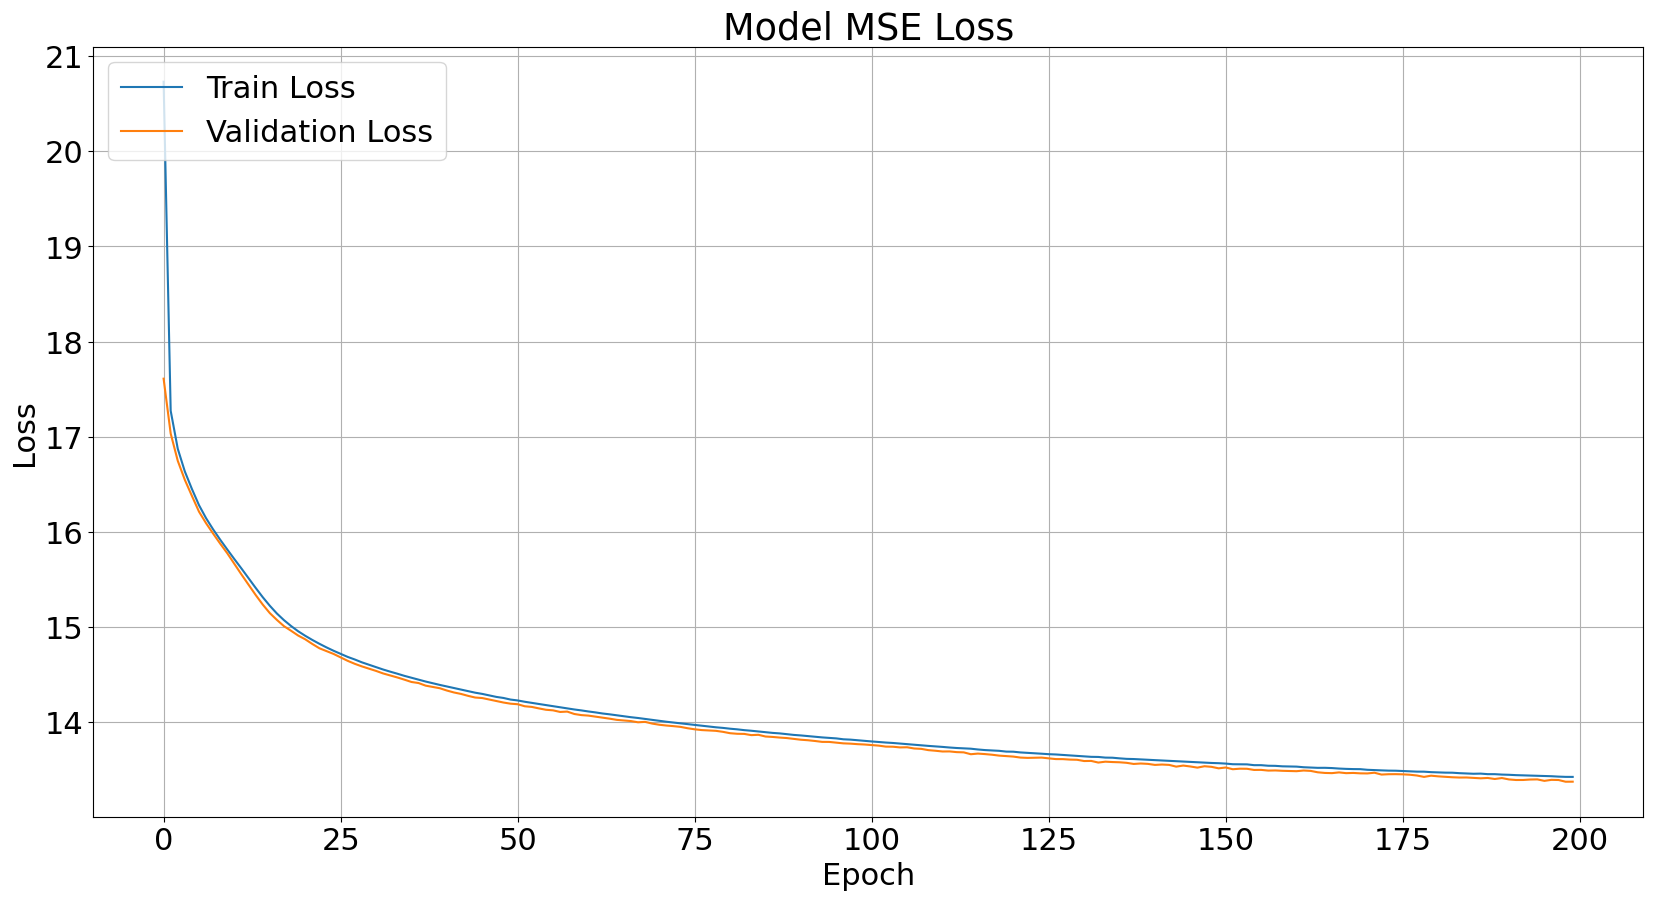

In [10]:
import pandas as pd
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_test_reconstruction_loss'])
plt.title('Model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
# plt.yscale('log')
plt.grid()
plt.savefig("plots/training_loss.pdf", format='pdf')
plt.show()

training_history = {}
training_history['train'] = history.history['reconstruction_loss']
training_history['test'] = history.history['val_test_reconstruction_loss']
df = pd.DataFrame(training_history)
df.to_csv("plots/training_loss.csv")

In [11]:
from datetime import datetime
now = datetime.now() # current date and time
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
idtag = date_time.replace(', ','-').replace('/','-').replace(':','-')
print(idtag)

autoencoder.save_weights("models/full-weights-"+idtag, save_format="tf")

12-16-2022-11-47-35


In [13]:
autoencoder.load_weights("models/full-weights-"+idtag)
autoencoder.compile(optimizer=keras.optimizers.Adam(lr = 1e-4), run_eagerly=True)

/home/pma/.conda/envs/ml_jax/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Test Reconstruction

1/1 [==============================] - 0s 33ms/step
(1, 16, 256, 1)


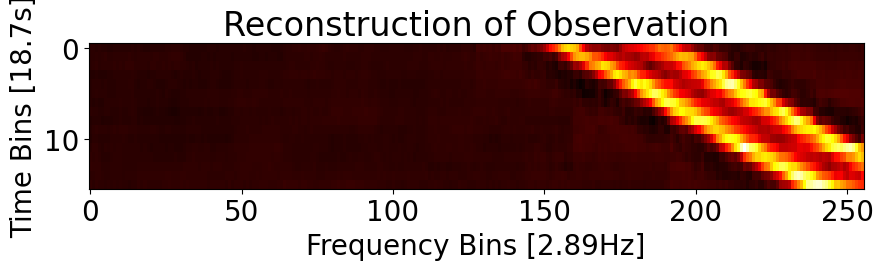

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 12

beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[index:index+1,:,:,:]))
print(beam_reconstruction.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Reconstruction of Observation")
plt.imshow(beam_reconstruction[0,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/reconstruction.pdf", format='pdf')


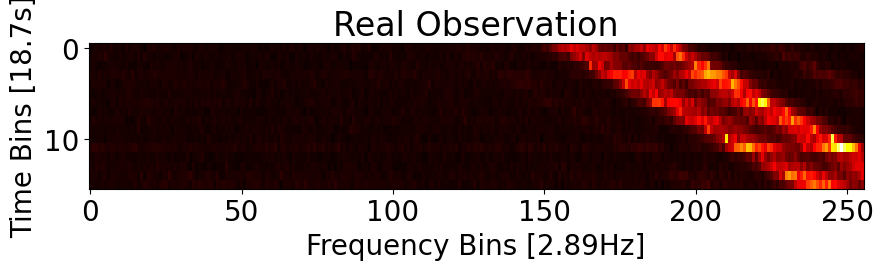

In [20]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.title("Real Observation")
plt.imshow(X_test[index,:,:,0], cmap='hot', interpolation='nearest', aspect=3)
plt.ylabel("Time Bins [18.7s]")
plt.xlabel("Frequency Bins [2.89Hz]")
plt.savefig("plots/real.pdf", format='pdf')

1/1 [==============================] - 0s 24ms/step


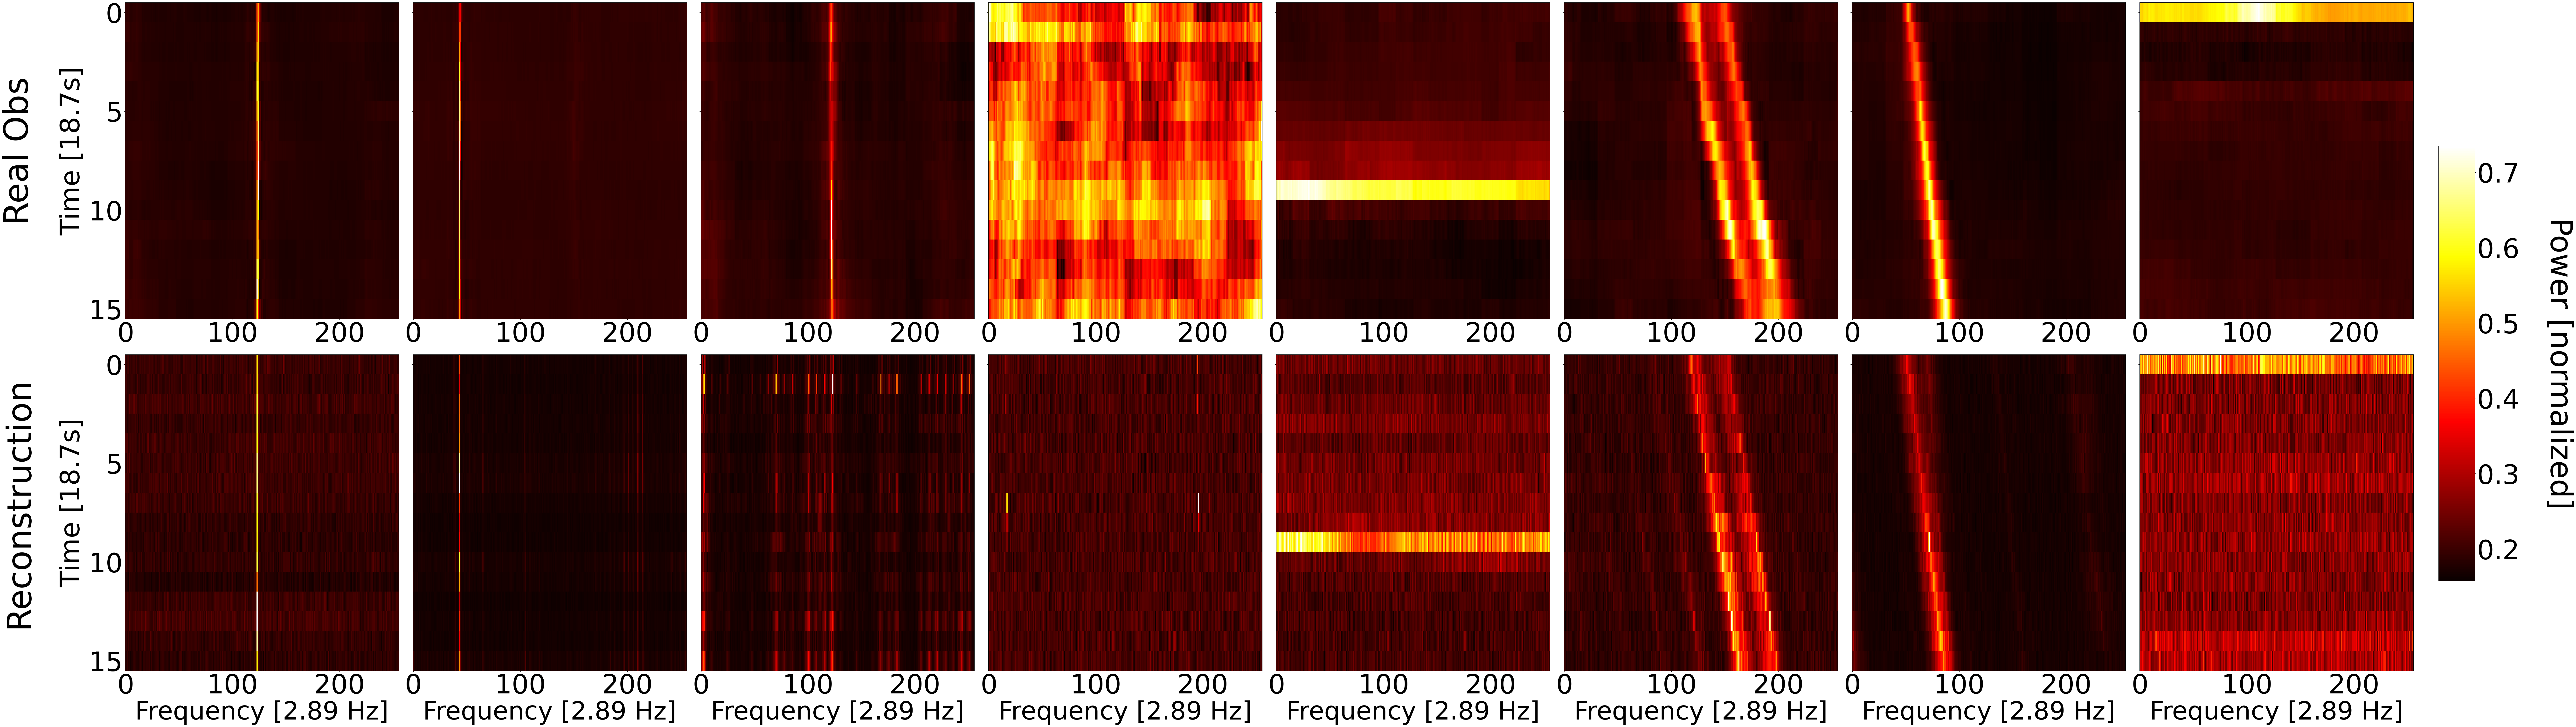

In [103]:
ind = np.random.randint(20_000, X_test.shape[0], size=(10))
font_size = 80
plt.rcParams.update({'font.size': font_size})

f, ax = plt.subplots(2, 8, sharey=True, figsize=(100, 30), constrained_layout=True)

for j in range(8):
    inde = ind[j]
    beam_reconstruction = autoencoder.decoder.predict(autoencoder.encoder.predict(X_test[inde:inde+1,:,:,:]))
    im = ax[0,j].imshow(beam_reconstruction[0,:,:,0], cmap='hot',
                        interpolation='nearest', aspect="auto")
    ax[1,j].imshow(X_test[inde,:,:,0], cmap='hot', interpolation='nearest', aspect="auto")
    if j == 0:
        ax[1,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
        ax[1,j].text(-100, 7, 'Reconstruction', ha='center', va='center', rotation='vertical', 
                     fontsize=font_size+20)
        ax[0,j].text(-100, 7, 'Real Obs', ha='center', va='center', rotation='vertical',  fontsize=font_size  +20)
        ax[0,j].text(-50, 7, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=font_size)
    ax[1,j].set_xlabel("Frequency [2.89 Hz]",  fontsize=font_size-5)  
    
cbaxes = f.add_axes([1.01, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.savefig("plots/reconstruction_test.pdf", format="pdf")
